In [4]:
!pip list
import os
#print (os.environ["CUDA_VISIBLE_DEVICES"])
os.environ["CUDA_VISIBLE_DEVICES"] = '4'
print (os.environ["CUDA_VISIBLE_DEVICES"])
#import model file
import torch


Package                Version
---------------------- ------------
aiohttp                3.8.1
aiosignal              1.2.0
argon2-cffi            21.3.0
argon2-cffi-bindings   21.2.0
asttokens              2.0.5
async-timeout          4.0.2
attrs                  21.4.0
backcall               0.2.0
beautifulsoup4         4.11.1
bleach                 4.1.0
brotlipy               0.7.0
cachetools             5.2.0
certifi                2022.6.15
cffi                   1.15.0
charset-normalizer     2.0.4
click                  8.1.3
colorama               0.4.4
conda                  4.13.0
conda-content-trust    0+unknown
conda-package-handling 1.8.1
cryptography           36.0.0
cycler                 0.11.0
datasets               2.3.2
debugpy                1.5.1
decorator              5.1.1
defusedxml             0.7.1
dill                   0.3.5.1
entrypoints            0.4
executing              0.8.3
fastjsonschema         2.15.1
filelock               3.7.1
fonttools        

In [5]:
import numpy as np
#import pandas as pd
from transformers import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from datasets import load_from_disk, load_metric
#import datasets
import pickle
#from utils.helper import read_py150k_code, read_file_to_string
import regex as re

In [6]:
#plbart init
#tokenizer = PLBartTokenizer.from_pretrained("uclanlp/plbart-base", src_lang="python", tgt_lang="python" )
#model = PLBartForConditionalGeneration.from_pretrained("uclanlp/plbart-base")
train_plbart_dataset = load_from_disk('datasets/plbart_train.hf')
test_plbart_dataset = load_from_disk('datasets/plbart_test.hf')
train_plbart_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_plbart_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

#codet5 init
tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-small')
#model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base')
train_codet5_dataset = load_from_disk('datasets/codet5_train.hf')
test_codet5_dataset = load_from_disk('datasets/codet5_test.hf')

def replaceNegative(label):
    #print (label['labels'])

    label['labels'] = [label['labels']]
    return label
def removeOutlier(example):
    #print (type(example['labels']))
    if example['labels'] != -1:
        example['labels'] = [example['labels'] + 1]
        return example
train_codet5_dataset = train_codet5_dataset.map(replaceNegative, batched = False)
test_codet5_dataset = test_codet5_dataset.map(replaceNegative, batched = False)
#test_codet5_dataset = test_codet5_dataset.map(removeOutlier, batched = False)
#train_codet5_dataset = train_codet5_dataset.map(removeOutlier, batched = False)
#train_codet5_dataset = train_codet5_dataset.filter(lambda example: example['labels'] != -1, batched=False)
#test_codet5_dataset = test_codet5_dataset.filter(lambda example: example['labels'] != 0, batched=False)
train_codet5_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_codet5_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])



loading file https://huggingface.co/Salesforce/codet5-small/resolve/main/vocab.json from cache at /soe/ksmunson/.cache/huggingface/transformers/12dd1d7e87ade1728f8382f3b875a47cdddb88bc50797ecc506957411661a39a.9a48c5abf25554713c6513ab01066e53569b9a2da0d6189715951cf7c6288805
loading file https://huggingface.co/Salesforce/codet5-small/resolve/main/merges.txt from cache at /soe/ksmunson/.cache/huggingface/transformers/c2ada6c76bb6a90c2330323775cb4853dd2b0cfee29d6b2c5ecb419c5874b488.7179059568f1a130b0a79e4bac71f38545207cab0ec45ce82ca09afadb2649a3
loading file https://huggingface.co/Salesforce/codet5-small/resolve/main/added_tokens.json from cache at /soe/ksmunson/.cache/huggingface/transformers/354ae288bdee65437fa8eedecf9a2770001b97bac23d7fc5a04badae8da42346.5cc6e825eb228a7a5cfd27cb4d7151e97a79fb962b31aaf1813aa102e746584b
loading file https://huggingface.co/Salesforce/codet5-small/resolve/main/special_tokens_map.json from cache at /soe/ksmunson/.cache/huggingface/transformers/f420b33feb234c

  0%|          | 0/172040 [00:00<?, ?ex/s]

  0%|          | 0/43010 [00:00<?, ?ex/s]

In [7]:

sorted_dataset = test_codet5_dataset.sort('labels')
sorted_dataset['labels']
#sorted_dataset = sorted_dataset.filter(lambda example: example['labels'] != 0, batched=False)

train_codet5_dataset = train_codet5_dataset.filter(lambda example: example['labels'][0] != -1, batched=False)
test_codet5_dataset = test_codet5_dataset.filter(lambda example: example['labels'][0] != -1, batched=False)
test_codet5_dataset['labels']

  0%|          | 0/173 [00:00<?, ?ba/s]

  0%|          | 0/44 [00:00<?, ?ba/s]

tensor([[22],
        [15],
        [ 6],
        ...,
        [19],
        [10],
        [ 5]])

In [8]:
#sample and save data subset
sorted_dataset = test_codet5_dataset.sort('labels')
sorted_dataset['labels']



tensor([[ 0],
        [ 0],
        [ 0],
        ...,
        [25],
        [25],
        [25]])

In [9]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, T5ForConditionalGeneration
model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-small', num_labels=26)
#add classification layer

loading configuration file https://huggingface.co/Salesforce/codet5-small/resolve/main/config.json from cache at /soe/ksmunson/.cache/huggingface/transformers/ef13e715cbf36adda46c74774e8032ab573cfbb2ebe59748c9fc72b7cf67e418.96d28e790b8c3d3e3be663606a66e0793a173c78e745e3603be4c0f878319099
Model config T5Config {
  "_name_or_path": "/content/drive/MyDrive/CodeT5/pretrained_models/codet5_small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "bos_token_id": 1,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 2,
  "feed_forward_proj": "relu",
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "

In [10]:
torch.version.cuda

'11.3'

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
print (os.environ["CUDA_VISIBLE_DEVICES"])
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")
metric = load_metric("accuracy")
def compute_metrics(eval_pred): # this part prob wont work, parameter should be removed from trainer probably
    try:
        logits, labels, inputs = eval_pred
    except:
        logits, labels = eval_pred
    predictions = np.argmax(logits[0], axis=-1)
    return metric.compute(predictions=predictions, references=labels)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


1


In [23]:

eval_dataset = test_codet5_dataset
eval_dataset = eval_dataset.train_test_split(test_size = 0.08)
print (eval_dataset)
model = T5ForConditionalGeneration.from_pretrained('./results/no_outlier_small/checkpoint-21000', num_labels=26)
#'Salesforce/codet5-small' 'results/no_dataloader/checkpoint-83500' /results/no_outlier/checkpoint-21000
training_args = TrainingArguments(
    output_dir="./results/no_outlier_small",
    learning_rate=1e-4, #2e-5, #
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=2000,
    eval_accumulation_steps=200,
)
#debug_dataset = 
print (training_args.device)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_codet5_dataset,
    eval_dataset=eval_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #data_collator=data_collator,
)

#trainer.train()

loading configuration file ./results/no_outlier/checkpoint-21000/config.json
Model config T5Config {
  "_name_or_path": "Salesforce/codet5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "bos_token_id": 1,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 2,
  "feed_forward_proj": "relu",
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LA

DatasetDict({
    train: Dataset({
        features: ['line_count', 'comment_count', 'comment_total_len', 'comment_avg_len', 'comment_density', 'id_total', 'lower_case', 'id_total_var', 'lower_case_var', 'snake_case_ratio', 'snake_case_var_ratio', 'snake_case_class_ratio', 'snake_case_method_ratio', 'lower_camel_case_ratio', 'lower_camel_case_var_ratio', 'lower_camel_case_class_ratio', 'lower_camel_case_method_ratio', 'upper_camel_case_ratio', 'upper_camel_case_var_ratio', 'upper_camel_case_class_ratio', 'upper_camel_case_method_ratio', 'lower_case_ratio', 'lower_case_var_ratio', 'lower_case_class_ratio', 'lower_case_method_ratio', 'upper_case_ratio', 'upper_case_var_ratio', 'upper_case_class_ratio', 'upper_case_method_ratio', 'other_case_ratio', 'other_case_var_ratio', 'other_case_class_ratio', 'other_case_method_ratio', 'func_decorators_avg', 'func_async_ratio', 'class_parents_avg', 'class_decorators_avg', 'ds_density', 'ds_char_len_avg', 'ds_word_len_avg', 'comprehensions_avg', 'gen

All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at ./results/no_outlier/checkpoint-21000.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


cuda:0


In [24]:

os.environ["CUDA_VISIBLE_DEVICES"] = '2, 0'
eval_dataset = test_codet5_dataset
eval_dataset = eval_dataset.train_test_split(test_size = 0.1)
#preds = trainer.predict(eval_dataset['test'])
preds = trainer.predict(test_codet5_dataset)
#model(eval_dataset['test']['input_ids'])


Loading cached split indices for dataset at datasets/codet5_test.hf/cache-00a291df77bfee92.arrow and datasets/codet5_test.hf/cache-dcb3fca6221388b8.arrow
The following columns in the test set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: class_parents_count, content, ds_char_len_avg, id_total_var, ds_count, lambda_avg, upper_camel_case, lower_camel_case, snake_case_class, lambda, upper_camel_case_ratio, lower_case_method_ratio, comment_avg_len, func_decorators_avg, lower_case_class, forks, ds_line_count, parse_error, snake_case_var_ratio, lower_case_ratio, snake_case_method_ratio, comment_density, other_case, filepath, ds_word_len_avg, func_count, upper_camel_case_method_ratio, other_case_method_ratio, ds_word_len_total, id_total_class, upper_camel_case_class, func_decorators_count, file, lower_case_var, ds_density, other_case_method, upper_camel_case_method, id_total_method, lower_camel_case_var_ratio, line_count, __index_level_0__,

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       136
           1       0.86      0.88      0.87       160
           2       0.98      0.98      0.98       103
           3       0.89      0.86      0.88        98
           4       0.93      0.91      0.92       189
           5       0.98      0.97      0.97       233
           6       0.95      0.93      0.94       763
           7       1.00      1.00      1.00      1009
           8       0.94      0.98      0.96       267
           9       0.78      0.86      0.82       206
          10       0.95      0.95      0.95      1113
          11       0.95      0.93      0.94       523
          12       0.85      0.82      0.83       115
          13       0.62      0.53      0.57       168
          14       0.89      0.87      0.88       178
          15       0.81      0.86      0.84       169
          16       0.78      0.84      0.81       538
          17       0.90    

In [25]:
import pandas as pd
print (preds[2])
from sklearn.metrics import classification_report
metric = load_metric("accuracy")
def compute_metrics(eval_pred): # this part prob wont work, parameter should be removed from trainer probably
    try:
        logits, labels, inputs = eval_pred
    except:
        logits, labels = eval_pred
    predictions = np.argmax(logits[0], axis=-1)
    df = pd.DataFrame(predictions)
    df.to_csv('./results/no_outlier_small/codet5_preds.csv')
    report =  (classification_report(labels, predictions))
    print (report)
    with open('./results/no_outlier_small/classification_report.txt', 'w') as f:
        f.write(report)
    return metric.compute(predictions=predictions, references=labels)

compute_metrics(preds)

#print ((preds[0][0]).tolist())
#prediction = pd.DataFrame(preds)
#display(prediction)
#prediction.to_csv('results/eval_83500.csv')
#predictions = pd.read_csv('plbart_preds.csv')
print (preds[1])
#print (classification_report(predictions, preds[1]))
print(sum(p.numel() for p in model.parameters()))
print ("new output")

{'test_loss': 0.40781378746032715, 'test_accuracy': 0.9204259438528558, 'test_runtime': 175.1017, 'test_samples_per_second': 58.994, 'test_steps_per_second': 3.689}
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       136
           1       0.86      0.88      0.87       160
           2       0.98      0.98      0.98       103
           3       0.89      0.86      0.88        98
           4       0.93      0.91      0.92       189
           5       0.98      0.97      0.97       233
           6       0.95      0.93      0.94       763
           7       1.00      1.00      1.00      1009
           8       0.94      0.98      0.96       267
           9       0.78      0.86      0.82       206
          10       0.95      0.95      0.95      1113
          11       0.95      0.93      0.94       523
          12       0.85      0.82      0.83       115
          13       0.62      0.53      0.57       168
          14       0.89 

In [26]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40,40)

[[ 128    0    0    0    3    0    0    0    0    1    2    0    0    0
     0    0    0    0    0    2    0    0    0    0    0    0]
 [   0  141    0    2    0    0    3    0    0    3    7    1    0    0
     0    1    0    0    0    2    0    0    0    0    0    0]
 [   0    0  101    0    0    1    0    0    0    1    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    4    0   84    0    0    3    0    0    0    5    1    0    0
     0    0    0    1    0    0    0    0    0    0    0    0]
 [   1    0    0    0  172    0    2    0    1    3    3    0    0    0
     0    0    0    0    1    6    0    0    0    0    0    0]
 [   0    0    1    1    0  225    3    0    0    0    2    0    0    0
     0    1    0    0    0    0    0    0    0    0    0    0]
 [   1    3    0    3    2    4  707    0    0   15   17    1    0    0
     1    4    0    2    0    3    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0 1006    0    2    

ValueError: The number of FixedLocator locations (26), usually from a call to set_ticks, does not match the number of ticklabels (10330).

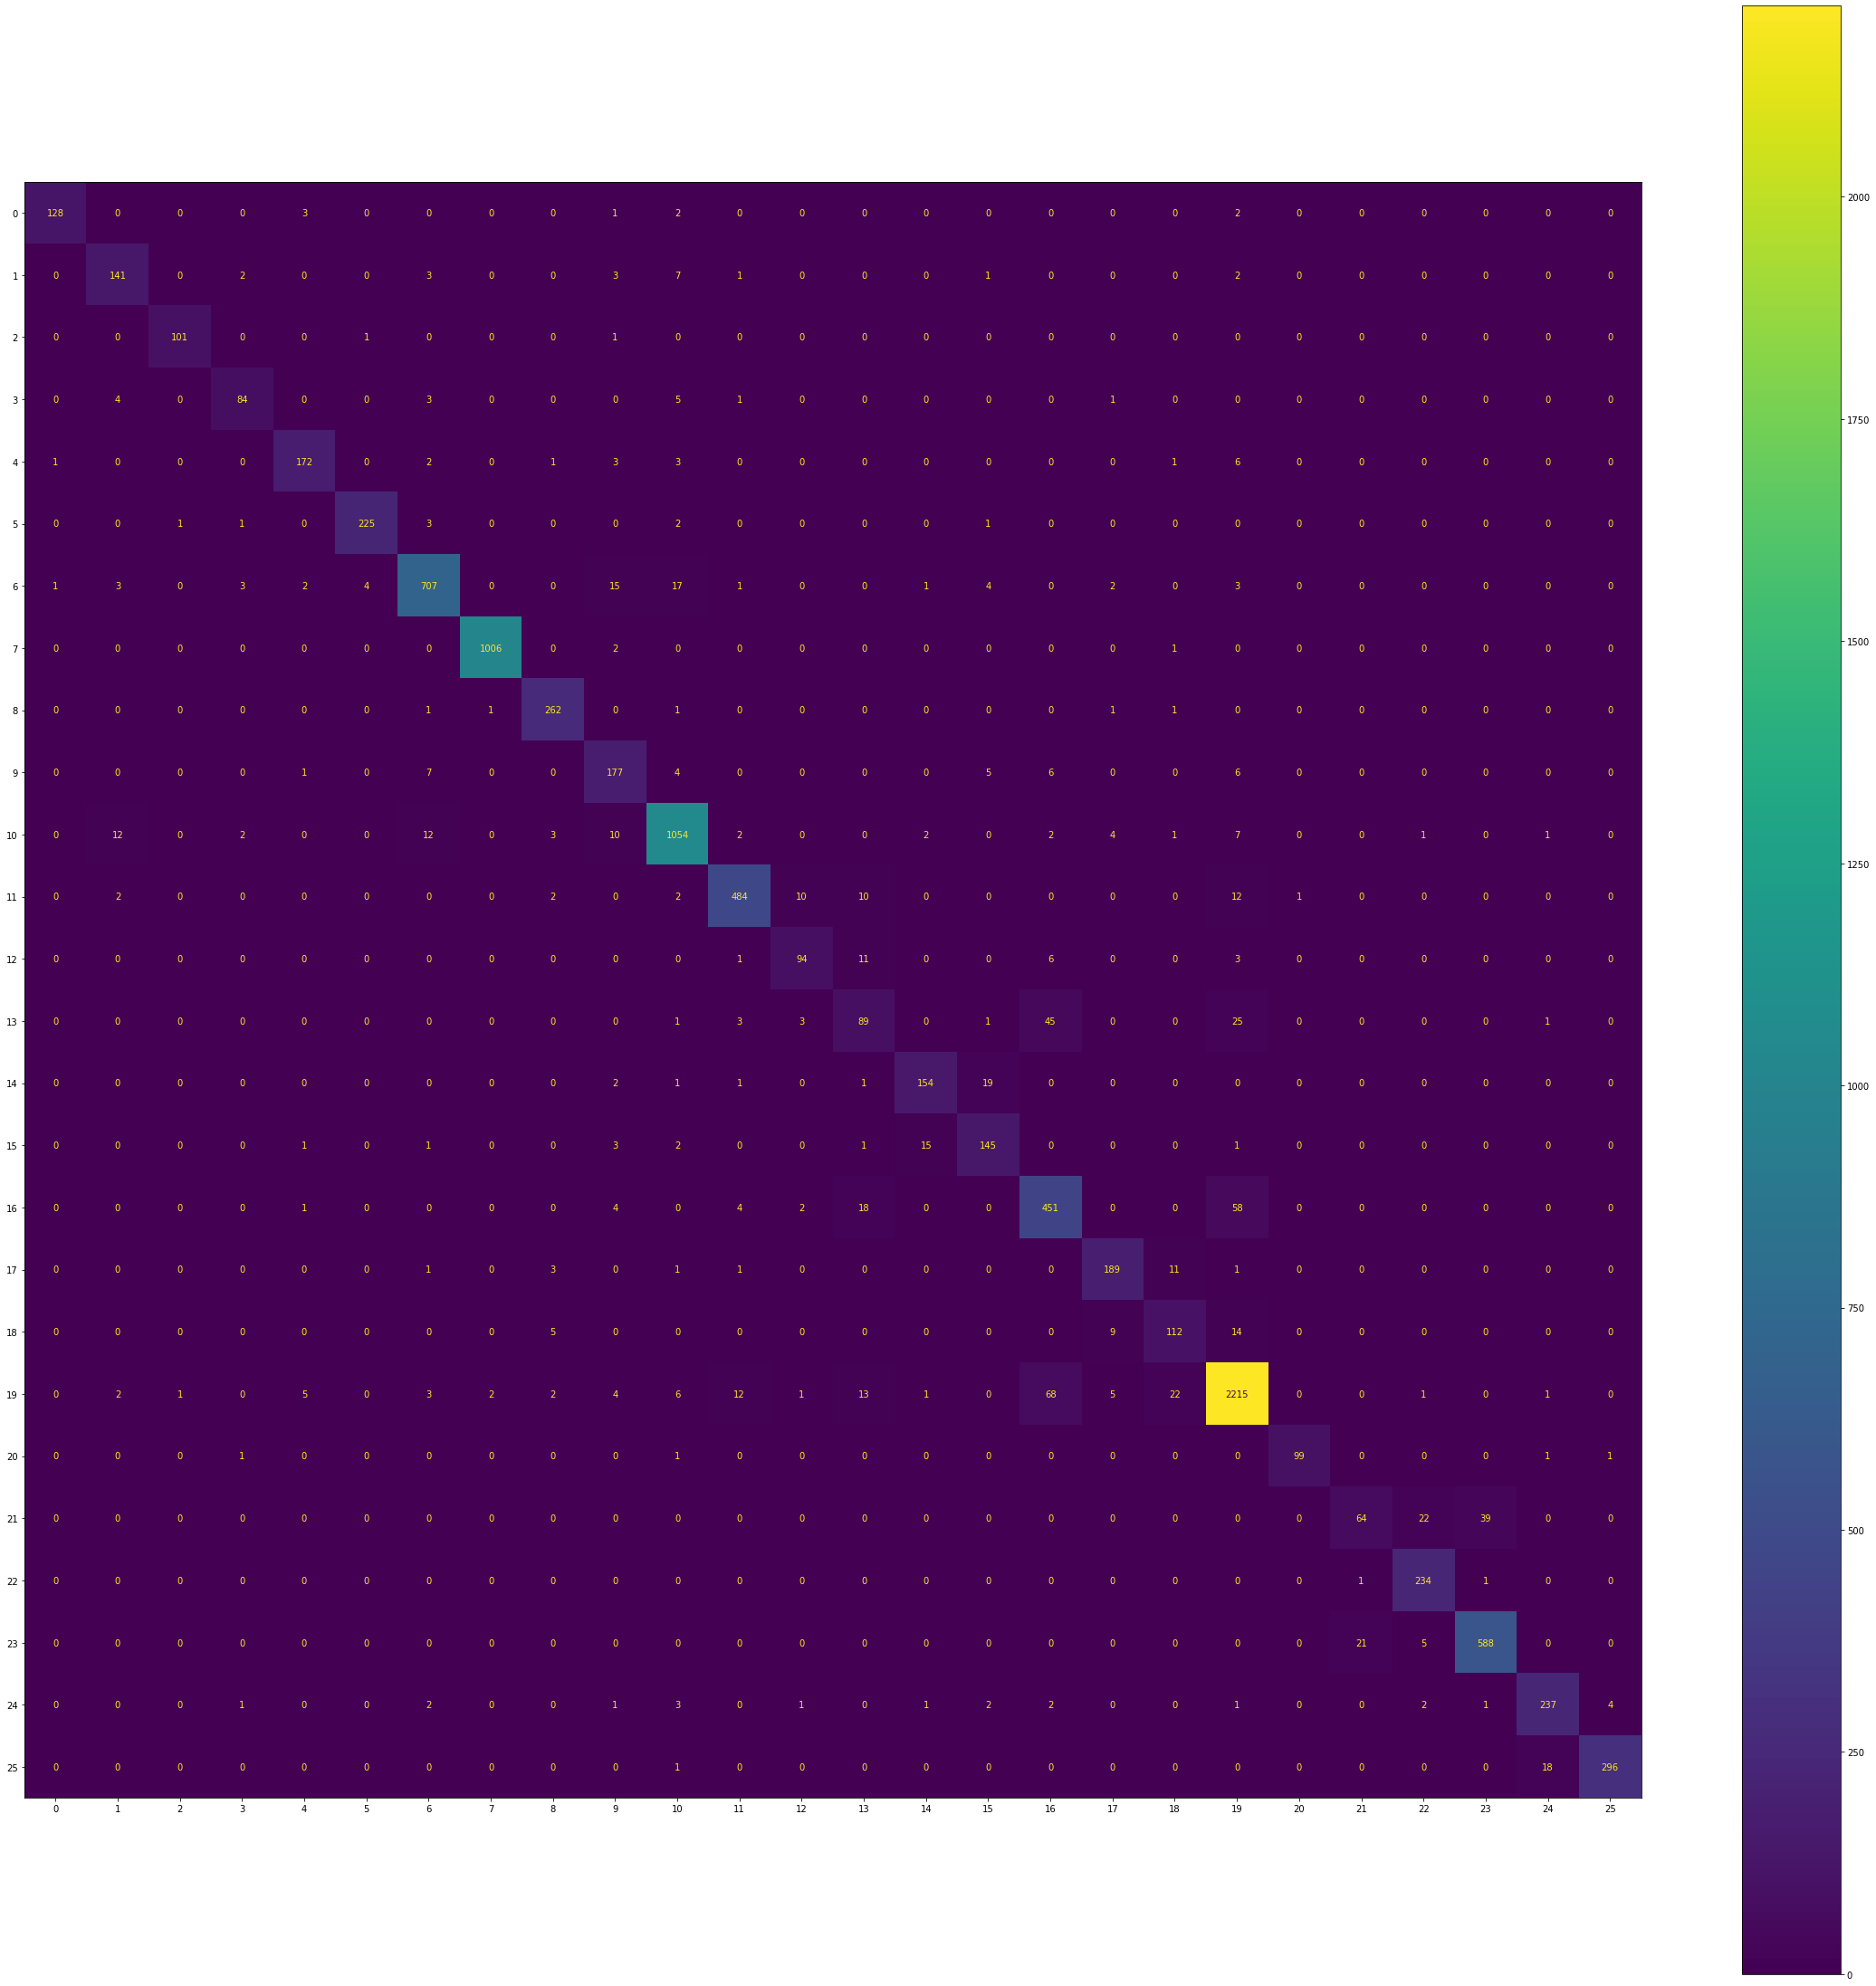

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
pred_labels =np.argmax(preds[0][0], axis=-1)
plt.rcParams["figure.figsize"] = (40,40)
true_labels =  (test_codet5_dataset['labels'])
cm = (confusion_matrix( true_labels, pred_labels))
print (cm)
classes = set(true_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()